# Credit-Card Default Risk
by Perry Shyr
## _5-of-7. Modeling with TensorFlow_
![](../image_files/cards.png)

## Problem Statement

Given a dataset with demographic and borrowing history data for accounts classified as defaulting or not defaulting in October-2005, can I build a supervised model that performs better than identifying only members of the negative non-default class (baseline model) while minimizing the misclassification of either class?  In the context of credit-card lending, if I can predict accounts as belonging to the defaulting class, I want to minimize the number of predicted defaulters who did not actually default that October (lost revenues) while minimizing the number of predicted non-defaulters who did end up defaulting (lost profits).

## Preamble for Modeling-with-TensorFlow Notebook

In this notebook, I follow up the Keras neural-networks model with grid-searching to confirm the best hyperparameters for Keras modeling arrived at in the previous notebook.  An alternative neural-networks model using TensorFlow is built below as well for comparison of performance.  I will use the True-positive rate and ROC-AUC measures for misclassification in the comparison. 


## A. Code Libraries Used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

/Users/perry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## B. Load data

In the last notebook I was manually editing which dataset I wasnted test, either the 23-feature-set or the 35-feature-set.  I made sense now to just import all the files I might use from the beginning.

In [2]:
accts_nf = pd.read_csv('../asset_files/credit_new_features.csv', index_col='ID')

In [3]:
print(accts_nf.shape)
accts_nf.head(5)

(29965, 43)


,credit_limit,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,gender_m,gender_f,edu_grad_schl,edu_college,edu_high_schl,edu_other,marital_mrrd,marital_sngl,marital_dvcd,marital_othr
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,1,0,0,1,0,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,1,0,0,0,1,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,1,0,0,0,1,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,1,0,0,1,0,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,1,0,0,1,0,0,1,0,0,0


In [4]:
X_train = pd.read_csv('../asset_files/X_train_split.csv', index_col='ID')
X_test = pd.read_csv('../asset_files/X_test_split.csv', index_col='ID')

X_train_sc = genfromtxt('../asset_files/X_train_scaled.csv', delimiter=',')
X_test_sc = genfromtxt('../asset_files/X_test_scaled.csv', delimiter=',')

X_train_sc = genfromtxt('../asset_files/X_train_scaled.csv', delimiter=',')
X_test_sc = genfromtxt('../asset_files/X_test_scaled.csv', delimiter=',')

In [7]:
y_train = pd.read_csv('../asset_files/y_train_split.csv', index_col=0, header=None)
y_test = pd.read_csv('../asset_files/y_test_split.csv', index_col=0, header=None)

I first imagined this notebook to support the previous notebook where I got an initial working model under my belt.  I considered applying some gradient descent and back-propagation technique, on top of building Grid-tuning for my Keras model and starting a TensorFlow model, but I learned from some reading from our local instruction Team (Douglas and Tim) that gradient-descent and back-propagation are already integrated into the loss-learning and optimizer components of our neural-network packages.

## C. GridSearchCV for Keras Model:

In [9]:
def model_func(layer_one_neurons=42, layer_one_dropout=.5):
    model = Sequential()
    model.add(Dense(layer_one_neurons, activation='relu', input_dim=42))
    model.add(Dense(layer_one_neurons, activation='relu', input_dim=42))
    model.add(Dropout(layer_one_dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='logcosh', optimizer='adam', metrics=['accuracy'])
    return model

nn = KerasClassifier(build_fn=model_func, verbose=0)
ss = StandardScaler()


pipe = Pipeline([
    ('ss', ss),
    ('nn', nn)
])

params = {
    'nn__epochs':[15, 20],
    'nn__batch_size':[35,150,300],
    'nn__layer_one_dropout': [.5,.6]
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8199172297970282


{'nn__batch_size': 150, 'nn__epochs': 20, 'nn__layer_one_dropout': 0.6}

In [10]:
gs.score(X_test, y_test)

0.8179391378937593

We see that the extended dataset with 12 additional features introduced some slight overfitting.  This was expected and consistent with my Keras testing in Notebook-4.  These best_params_ are very close to where I chose values for manual testing.

## D. Neural-network model using TensorFlow:

In [11]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [13]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,42))
y = tf.placeholder(dtype=tf.float32, shape=(None,1))

h1 = tf.layers.dense(X, 42, activation=tf.nn.relu)
# h2 = tf.layers.dense(h1, 42, activation=tf.nn.relu)  # Second hidden layer excluded.
# h3 = tf.layers.dense(h2, 42, activation=tf.nn.relu)  # Third hidden layer excluded
y_hat = tf.layers.dense(h1, 1, activation=tf.nn.sigmoid)

loss = tf.losses.sigmoid_cross_entropy(y,y_hat)
optimizer = tf.train.AdamOptimizer(.01)
training_op = optimizer.minimize(loss)

The model results were worse for a second or third hidden layers.

In [14]:
init = tf.global_variables_initializer()

train_losses = []
test_losses = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(100):
        sess.run(training_op, feed_dict={X: X_train_sc, y: y_train})
        trl = sess.run(loss,feed_dict = {X:X_train_sc,y:y_train})
        tsl = sess.run(loss,feed_dict = {X:X_test_sc,y:y_test})
        
        train_losses.append(trl)
        test_losses.append(tsl)
    pred = sess.run(y_hat, feed_dict={X:X_test_sc})

There is an alternative to using 'feed-dict' involving a built-in API named 'Dataset.' (https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)

(Note: I added this research here planning to revisit it's use at some point.)

In [15]:
predicted_classes = (pred > .10).astype(int)   # threshold set at 0.1

In [16]:
print(np.sum(pred))
pred                # ...is an array of continuous probabilities

515.8538


array([[2.4473325e-03],
       [5.9563723e-07],
       [2.0784936e-03],
       ...,
       [1.3216457e-05],
       [7.2859613e-05],
       [1.4281904e-04]], dtype=float32)

In [17]:
np.max(predicted_classes)
predicted_classes   # ...is an array of integers.

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [18]:
metrics.accuracy_score(y_test,predicted_classes)

0.8142018152696209

We can see that the score is almost as good as the Keras score, but not quite.

In [19]:
metrics.confusion_matrix(y_test, predicted_classes)

array([[5544,  290],
       [1102,  556]])

The True-Positive Rate (TPR) for this model is ...

In [20]:
556 / (556+1102)

0.3353437876960193

... 33.5% for the discrete classification.

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, [np.around(y) for y in predicted_classes]).ravel()
df_cm1 = pd.DataFrame(confusion_matrix(y_test, 
                                       [np.around(y) for y in predicted_classes]), 
                      columns=["","Actual Oct-Default"])

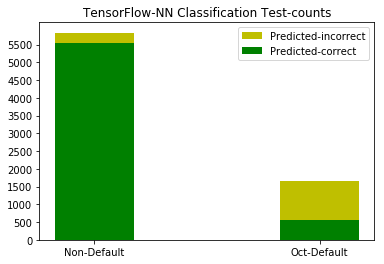

In [25]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pred_right, width, color='g')
p2 = plt.bar(ind, pred_wrong, width, color='y',
             bottom=pred_right)

plt.title('TensorFlow-NN Classification Test-counts')
plt.xticks(ind, ('Non-Default', 'Oct-Default'))
plt.yticks(np.arange(0, 6000, 500))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

We can see that the TensorFlow model suffers from incorrectly predicting the non-default status of accounts that actually defaulted.  In financial terms, this is extremely costly.

Let's plot the loss history.

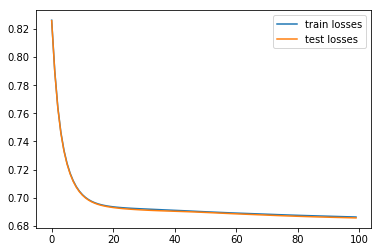

In [38]:
plt.plot(train_losses,label='train losses')
plt.plot(test_losses,label='test losses')
plt.legend()

We can see that there is almost no variance problem.

Then, we can look at the Receiver-Operator Characteristic plot for the misclassification rate of the probailities.

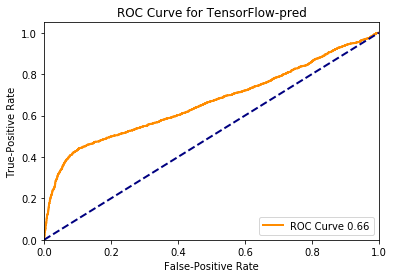

In [26]:
from sklearn.metrics import roc_curve, auc

# Generate False positive rate and True positive rate
# fpr, tpr, _ = roc_curve(y_test, predicted_classes)
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# fpr

# Plot 
plt.figure()
line_width = 2

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1],[0,1], lw = line_width, linestyle = "--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC Curve for TensorFlow-pred')
plt.legend(loc="lower right")
plt.show()

The same plot for the discrete predictions from an adjusted threshold.

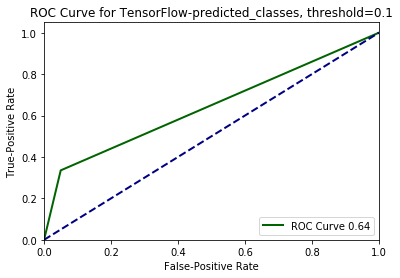

In [27]:
fpr, tpr, _ = roc_curve(y_test, predicted_classes)
roc_auc = auc(fpr, tpr)
# fpr

# Plot 
plt.figure()
line_width = 2

plt.plot(fpr, tpr, lw = line_width, color="darkgreen", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1],[0,1], lw = line_width, linestyle = "--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC Curve for TensorFlow-predicted_classes, threshold=0.1')
plt.legend(loc="lower right")
plt.show()

The area measured is slightly less with an adjusted threshold.

## Continue to Notebook-6: Modeling Other Classifiers - Part 3

The tuning of the Keras model from Notebook-4 used GridSearch in the current notebook above.  A comparable Tensorflow version was built without a workable way to save it.  Based on a higher TPR score (0.353 to be confirmed in Notebook-7), the Keras model will be considered for the final evaluation.  As a result, saving the current Tensorflow model is not a necessity for the time being.

In the next notebook, we build three basic classifier models, including Logistic Regression, Naive-Bayes, and DecisionTreeClassifier.  The best two of those models will be saved and considered for final evaluation in the last notebook in this kernel.